In [121]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import GPy

# Parameters
n_stations = 5
n_time = 100
station_ids = np.arange(n_stations)  # Zero-based indexing for stations
time = np.linspace(0, 10, n_time)

# Generate random latitudes and longitudes for each station
latitudes = np.random.uniform(30, 35, n_stations)
longitudes = np.random.uniform(-90, -80, n_stations)

# Create an xarray Dataset to hold the data
dataset = xr.Dataset(coords={"station_id": station_ids, "time": time})
dataset['lat'] = ('station_id', latitudes)
dataset['lon'] = ('station_id', longitudes)


In [122]:
# Define spike parameters
spike_time = 5.0  # Time when the spike occurs
spike_duration = 6  # Number of time steps for the spike
spike_magnitude = 30.0  # Magnitude of the spike
spike_stddev = 0.2  # Standard deviation for the Gaussian spike

# Define a Gaussian function for the spike
def gaussian(x, mean, amplitude, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Create the Gaussian spike
x_spike = np.linspace(-1, 1, spike_duration)
spike = gaussian(x_spike, mean=0, amplitude=spike_magnitude, stddev=spike_stddev)

# Initialize temperature data
dataset['temperature'] = (('station_id', 'time'), np.empty((n_stations, n_time)) * np.nan)

# Generate temperature data for each station
for i in range(n_stations):
    # Base temperature signal
    base_temp = (
        20 + 5 * np.exp(-0.2 * time) +
        (i + 1) * 1.5 * np.sin(2 * np.pi * time / 5) +
        np.random.normal(0, (i + 1) * 0.5, n_time)
    )
    # Introduce the spike
    spike_time_index = np.argmin(np.abs(time - spike_time))
    base_temp[spike_time_index - spike_duration // 2 : spike_time_index + spike_duration // 2] += spike
        
    # Assign to dataset
    dataset['temperature'].isel(station_id=i).values[:] = base_temp


In [123]:
# Select a target station
target_station_id = 2  # For example, station 2

# Remove the spike from the target station to simulate missing data
spike_time_index_target = np.argmin(np.abs(time - spike_time))
missing_indices = slice(spike_time_index_target - spike_duration // 2, spike_time_index_target + spike_duration // 2)
dataset['temperature'].sel(station_id=target_station_id).isel(time=missing_indices).values[:] = np.nan


In [297]:
# Prepare data for the GPCoregionalizedRegression model
X_list = []
Y_list = []

for station_id in dataset['station_id'].values:
    # Extract data for the station
    lat = dataset['lat'].sel(station_id=station_id).values
    lon = dataset['lon'].sel(station_id=station_id).values
    time_values = dataset['time'].values
    temp_values = dataset['temperature'].sel(station_id=station_id).values

    # Remove NaN values (missing data)
    valid_mask = ~np.isnan(temp_values)
    time_valid = time_values[valid_mask]
    temp_valid = temp_values[valid_mask]

    # Create input array: [latitude, longitude, time]
    X_station = np.column_stack([
        np.full_like(time_valid, lat),
        np.full_like(time_valid, lon)
    ])
    # Output array: temperature values
    Y_station = temp_valid[:, None]  # Ensure Y is a 2D array

    X_list.append(X_station)
    Y_list.append(Y_station)


In [339]:
# Number of outputs (stations)
num_outputs = n_stations
n_inputs = 2
K1 = GPy.kern.Bias(input_dim=n_inputs)
K2 = GPy.kern.Linear(input_dim=n_inputs)
K3 = GPy.kern.Matern32(input_dim=n_inputs)
lcm_kernel = GPy.util.multioutput.LCM(input_dim=n_inputs,num_outputs=n_stations,kernels_list=[K1,K2,K3], W_rank = 5)


model = GPy.models.GPCoregionalizedRegression(X_list, Y_list, kernel=lcm_kernel)

# Optimize the model
model.optimize(messages=True, max_iters=1000)

In [384]:
# Prepare test inputs for the missing data at the target station
temp_target = dataset['temperature'].sel(station_id=target_station_id).values
missing_mask = np.isnan(temp_target)
time_missing = dataset['time'].values[missing_mask]
lat_target = dataset['lat'].sel(station_id=target_station_id).values
lon_target = dataset['lon'].sel(station_id=target_station_id).values

# Create input array for prediction: [latitude, longitude, time]
X_new = np.column_stack([
    np.full_like(time_missing, lat_target),
    np.full_like(time_missing, lon_target)
])

# Predict missing values for the target station
Y_pred, Y_var = model.predict(X_new, Y_metadata = {"output_index":model.Y_metadata["output_index"]})

IndexError: index 2 is out of bounds for axis 1 with size 2

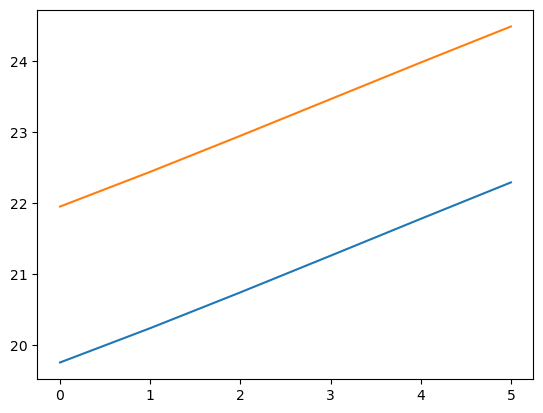

In [193]:
plt.plot(Y_pred)
plt.plot(Y_pred + np.sqrt(Y_var)

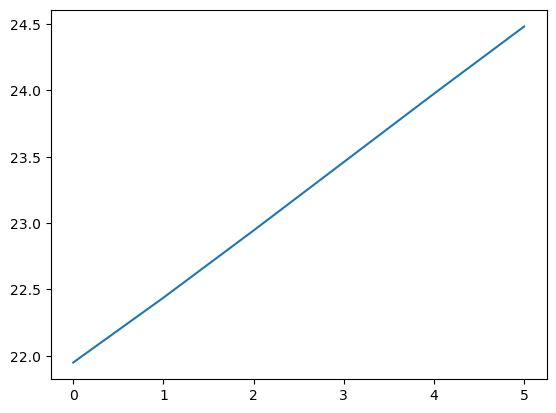

In [51]:
# Prepare test inputs for the missing data at the target station
target_station_idx = target_station_id - 1  # Zero-based index
temp_target = dataset['temperature'].sel(station_id=target_station_id).values
missing_mask = np.isnan(temp_target)
time_missing = dataset['time'].values[missing_mask]
lat_target = dataset['lat'].sel(station_id=target_station_id).values
lon_target = dataset['lon'].sel(station_id=target_station_id).values

# Create input array for prediction: [latitude, longitude, time, output_index]
X_new = np.column_stack([
    lat_target * np.ones_like(time_missing),
    lon_target * np.ones_like(time_missing),
    time_missing,
    np.full(len(time_missing), target_station_idx)
])

# Predict missing values
Y_pred, Y_var = m.predict(X_new[:, :])


TypeError: 'NoneType' object is not subscriptable

In [31]:
X_new.shape

(12, 3)

In [21]:
# Prepare test inputs for the missing data at the target station
target_station_idx = target_station_id - 1  # Zero-based index
temp_target = dataset['temperature'].sel(station_id=target_station_id).values
missing_mask = np.isnan(temp_target)
time_missing = dataset['time'].values[missing_mask]
lat_target = dataset['lat'].sel(station_id=target_station_id).values
lon_target = dataset['lon'].sel(station_id=target_station_id).values

# Create input array for prediction
X_missing = np.column_stack([
    lat_target * np.ones_like(time_missing),
    lon_target * np.ones_like(time_missing),
    time_missing
])

# The model expects inputs with the output index appended
# Create a list of arrays with the output index
X_new_list = []
for t in range(len(time_missing)):
    X_new_list.append(np.hstack([X_missing[t], [target_station_idx]]))

X_new = np.array(X_new_list)

# Predict missing values
Y_pred, Y_var = m.predict(np.array([X_new[:, 0], X_new[:, 1], X_new[:, 2]]))

# Extract predicted values and uncertainties
predicted_values = Y_pred[0][:, 0]
predicted_std = np.sqrt(Y_var[0][:, 0])


IndexError: index 33 is out of bounds for axis 0 with size 5

## Now try GPR with ten buoys and xarray!

In [25]:
# Create synthetic xarray dataset with (space, time) dimensions
n_space = 10  # Number of spatial points (buoys)
n_time = 100  # Number of time points

time = np.linspace(0, 10, n_time)
space = np.arange(n_space)

# Define random lat/lon positions for the buoys (latitude: 40-45N, longitude: 70-75W)
latitudes = 40 + 5 * np.random.rand(n_space)
longitudes = -75 + 5 * np.random.rand(n_space)

# Generate synthetic temperature data for each spatial point with interannual variability
interannual_variability = 1.5 * np.sin(2 * np.pi * time / 5)
baseline_temperature = 20 + 5 * np.exp(-10 * time)

# Randomly varying the baseline temperatures for each spatial location
temperature_data = np.array([baseline_temperature + interannual_variability * _ + np.random.normal(0, 0.2, n_time) 
                             for _ in range(n_space)])

ngaps = 5  # Number of chunks
chunk_size = n_time // 10

# Create gaps in temperature data
for i in range(n_space):
    gap_indices = create_gap_chunks(n_time, ngaps, chunk_size)
    temperature_data[i, gap_indices] = np.nan

# Create xarray Dataset
ds = xr.Dataset(
    {
        'temperature': (['space', 'time'], temperature_data)
    },
    coords={
        'space': space,
        'time': time,
        'lat': ('space', latitudes),
        'lon': ('space', longitudes)
    }
)

# Prepare data for GPR
temperature_flat = ds['temperature'].stack(z=('space', 'time')).values  # Flatten space-time dimensions
valid_indices = ~np.isnan(temperature_flat)

# Create 2D spatial coordinates (lat/lon) + time for GPR
coords_flat = np.array([[ds['lat'].values[s], ds['lon'].values[s], t] for s in ds['space'].values for t in ds['time'].values])

# Filter out valid (non-NaN) temperature values and coordinates
valid_coords = coords_flat[valid_indices]
valid_temperature = temperature_flat[valid_indices]

# ---- Gaussian Process Regression (GPR) ----
# Define GPR kernel (RBF for space + time)
kernel = GPy.kern.RBF(input_dim=3, lengthscale=1.0, variance=1.0) + GPy.kern.Bias(input_dim=3)

# GPR model using the valid (non-missing) data
gpr_model = GPy.models.GPRegression(valid_coords, valid_temperature[:, None], kernel)
gpr_model.optimize()

# Predict the temperature for the entire dataset
gpr_pred, gpr_var = gpr_model.predict(coords_flat)

# Reshape the predictions back into the original dataset shape (space, time)
pred_temperature = gpr_pred.reshape(n_space, n_time)
var_temperature = gpr_var.reshape(n_space, n_time)

# Add the GPR-predicted values into the xarray dataset
ds['temperature_filled_gpr'] = (['space', 'time'], pred_temperature)
ds['gpr_variance'] = (['space', 'time'], var_temperature)

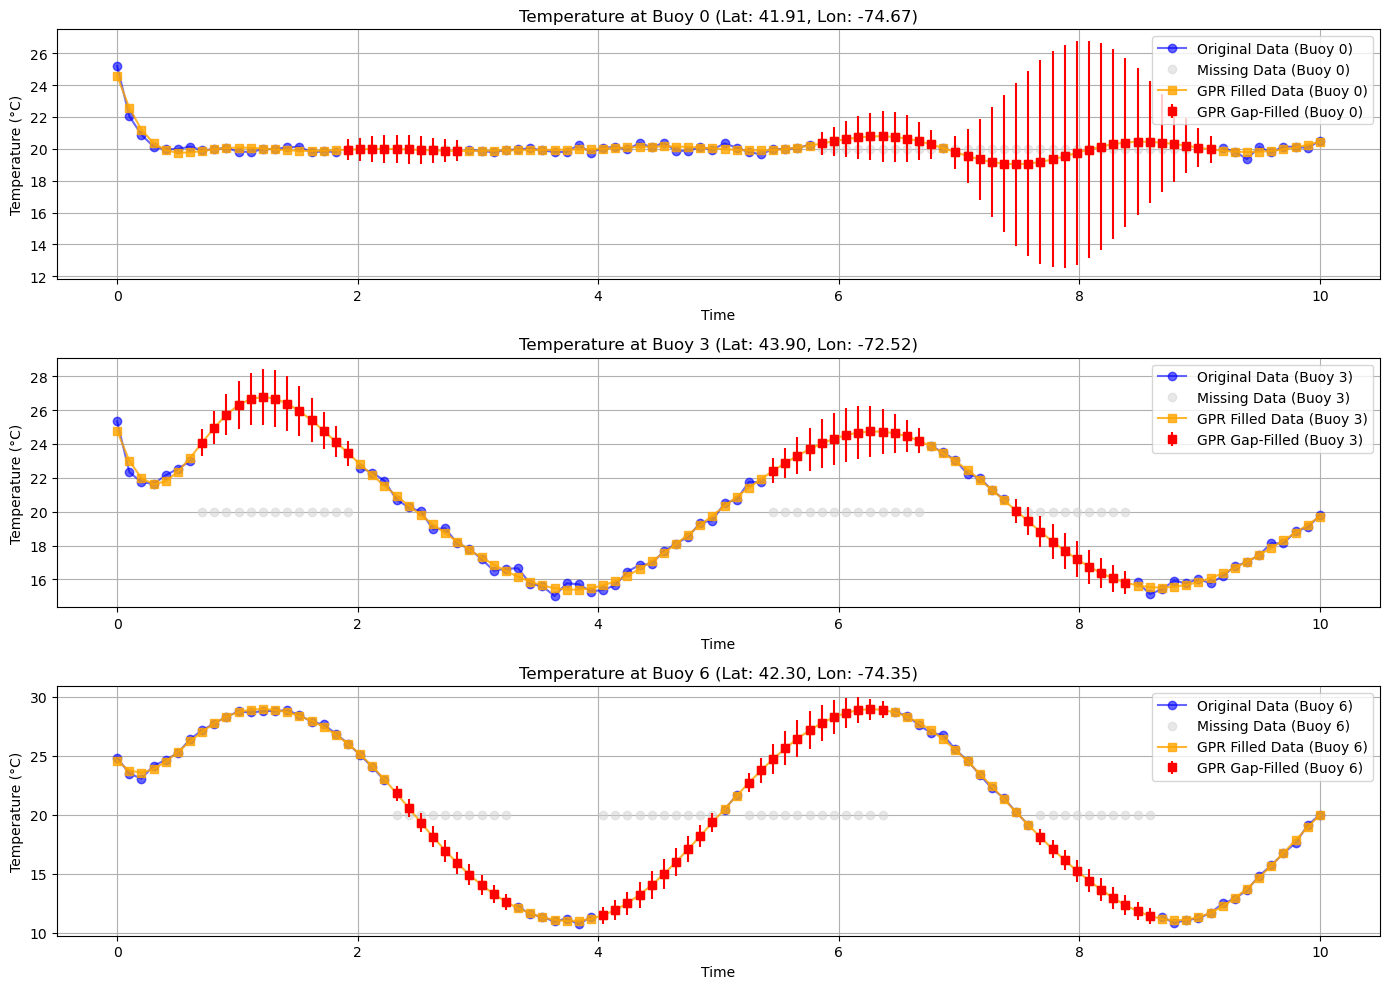

In [26]:
# ---- Plot the Before and After GPR Time Series for a Few Spatial Points ----
fig, axs = plt.subplots(3, 1, figsize=(14, 10))

for i, ax in enumerate(axs):
    space_point = i * (n_space // 3)  # Select 3 space points to visualize

    time = ds['time'].values
    temp_original = ds['temperature'].isel(space=space_point).values
    temp_filled = ds['temperature_filled_gpr'].isel(space=space_point).values
    temp_var = ds['gpr_variance'].isel(space=space_point).values

    gap_indices = np.where(np.isnan(temp_original))[0]

    # Plot original data with missing points
    ax.plot(time, temp_original, 'o-', label=f'Original Data (Buoy {space_point})', color='blue', alpha=0.6)
    
    # Plot the missing data in a lighter color
    ax.plot(time[gap_indices], np.full_like(gap_indices, np.nanmean(temp_filled)), 'o', color='lightgray', label=f'Missing Data (Buoy {space_point})', alpha=0.5)
    
    # Plot GPR-filled data
    ax.plot(time, temp_filled, 's-', label=f'GPR Filled Data (Buoy {space_point})', color='orange', alpha=0.8)
    
    # Plot error bars for the filled data at gap indices
    ax.errorbar(time[gap_indices], temp_filled[gap_indices], yerr=2*np.sqrt(temp_var[gap_indices]), fmt='s', color='red', label=f'GPR Gap-Filled (Buoy {space_point})')

    ax.set_title(f'Temperature at Buoy {space_point} (Lat: {ds["lat"].values[space_point]:.2f}, Lon: {ds["lon"].values[space_point]:.2f})')
    ax.set_xlabel('Time')
    ax.set_ylabel('Temperature (°C)')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
